# Smoker classification using XGBoost classifier

The data used for this notebook is from the UK Smoking Habits Survey. This dataset was taken from [Kaggle](https://www.kaggle.com/datasets/utkarshx27/smoking-dataset-from-uk). We will first analyze the data through visualization and then try to predict whether a person is a smoker or a non-smoker using XGBoost classifier.

Table of Contents:
1. [Preparing the dataset](#1)<br>
    1.1 [Loading the dataset](#1_1)<br>
    1.2 [Preprocessing](#1_2)<br>
2. [Visualization](#2)<br>
    2.1 [Gender](#2_1)<br>
    2.2 [Age](#2_2)<br>
    2.3 [Marital Status](#2_3)<br>
    2.4 [Highest Qualification](#2_4)<br>
    2.5 [Nationality](#2_5)<br>
    2.6 [Ethnicity](#2_6)<br>
    2.7 [Gross Income](#2_7)<br>
    2.8 [Region](#2_8)<br>
    2.9 [Smoke](#2_9)<br>
3. [XGBoost Classification](#3)<br>
    3.1 [Encoding categorical columns](#3_1)<br>
    3.2 [Splitting the data and dealing with class imbalance](#3_2)<br>
    3.3 [Creating the XGB model and tuning hyperparameters via grid search](#3_3)<br>
    3.4 [Performace evaluation](#3_4)<br>

## 1. Preparing the dataset <a id='1'></a>

### 1.1 Loading the dataset <a id='1_1'></a>

In [1]:
import pandas as pd

smoking_df = pd.read_csv('../smoking.csv', index_col='id')
print(f'Number of rows/columns : {smoking_df.shape}\n')
print(f'Column names: {smoking_df.columns.values}')

Number of rows/columns : (1691, 12)

Column names: ['gender' 'age' 'marital_status' 'highest_qualification' 'nationality'
 'ethnicity' 'gross_income' 'region' 'smoke' 'amt_weekends' 'amt_weekdays'
 'type']


### 1.2 Preprocessing <a id='1_2'></a>

In [2]:
# We won't need last three columns, so we can drop them.
smoking_df = smoking_df.iloc[:, :-3]
smoking_df

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke
id,,,,,,,,,
1,Male,38,Divorced,No Qualification,British,White,"2,600 to 5,200",The North,No
2,Female,42,Single,No Qualification,British,White,"Under 2,600",The North,Yes
3,Male,40,Married,Degree,English,White,"28,600 to 36,400",The North,No
4,Female,40,Married,Degree,English,White,"10,400 to 15,600",The North,No
5,Female,39,Married,GCSE/O Level,British,White,"2,600 to 5,200",The North,No
...,...,...,...,...,...,...,...,...,...
1687,Male,22,Single,No Qualification,Scottish,White,"2,600 to 5,200",Scotland,No
1688,Female,49,Divorced,Other/Sub Degree,English,White,"2,600 to 5,200",Scotland,Yes
1689,Male,45,Married,Other/Sub Degree,Scottish,White,"5,200 to 10,400",Scotland,No


In [3]:
smoking_df['gross_income'].value_counts()

5,200 to 10,400     396
10,400 to 15,600    268
2,600 to 5,200      257
15,600 to 20,800    188
20,800 to 28,600    155
Under 2,600         133
Refused             108
Above 36,400         89
28,600 to 36,400     79
Unknown              18
Name: gross_income, dtype: int64

In [4]:
# Since there are only 18 instances of 'Unknown' gross income, we can remove them.
smoking_df = smoking_df[smoking_df['gross_income'] != 'Unknown']

In [5]:
smoking_df['ethnicity'].value_counts()

White      1543
Asian        41
Black        34
Chinese      27
Mixed        14
Refused      12
Unknown       2
Name: ethnicity, dtype: int64

In [6]:
smoking_df['nationality'].value_counts()

English     819
British     537
Scottish    141
Other        71
Welsh        66
Irish        22
Refused      16
Unknown       1
Name: nationality, dtype: int64

In [7]:
# We can do the same for the 'Unknown' instances of ethnicity and natoinality.
smoking_df = smoking_df[smoking_df['ethnicity'] != 'Unknown']
smoking_df = smoking_df[smoking_df['nationality'] != 'Unknown']

## 2. Visualization <a id='2'></a>

Let's compare the values in our categorical variables to better understand the data.

### 2.1 Gender <a id='2_1'></a>

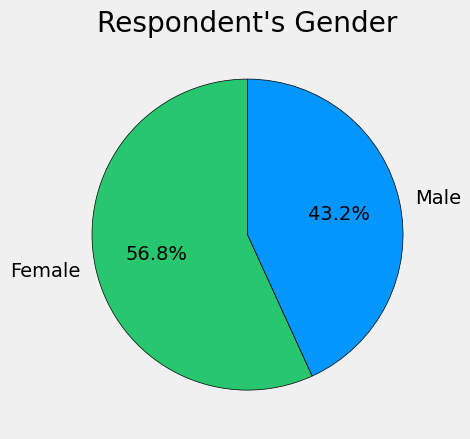

In [8]:
from matplotlib import pyplot as plt

plt.style.use("fivethirtyeight")
slices = [smoking_df['gender'].value_counts()[0], smoking_df['gender'].value_counts()[1]]
labels = ['Female', 'Male']
c = ['#28C76F', '#0396FF']

plt.pie(slices, labels=labels, startangle=90, autopct='%1.1f%%', colors=c, 
        wedgeprops={'edgecolor': 'black'})

plt.title("Respondent's Gender")
plt.show()

### 2.2 Age <a id='2_2'></a>

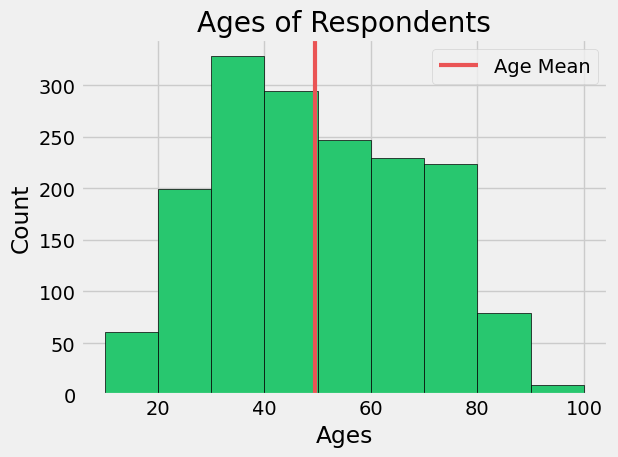

In [9]:
import numpy as np

ages = smoking_df['age']
bins = np.linspace(10, 100, num=10)

plt.hist(ages, bins=bins, edgecolor='black', color='#28C76F')

mean_age = ages.mean()
color = '#EA5455'

plt.axvline(mean_age, color=color, label='Age Mean', linewidth=3)

plt.legend()

plt.title('Ages of Respondents')
plt.xlabel('Ages')
plt.ylabel('Count')

plt.tight_layout()

plt.show()

### 2.3 Marital Status <a id='2_3'></a>

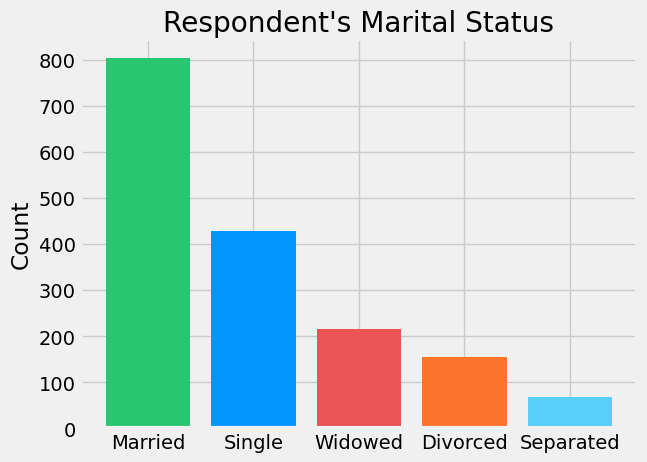

In [10]:
counts = [smoking_df['marital_status'].value_counts()[0], smoking_df['marital_status'].value_counts()[1], 
         smoking_df['marital_status'].value_counts()[2], smoking_df['marital_status'].value_counts()[3],
         smoking_df['marital_status'].value_counts()[4]]
labels = ['Married', 'Single', 'Widowed', 'Divorced', 'Separated']
c = ['#28C76F', '#0396FF', '#EA5455', '#FA742B', '#58CFFB']

plt.bar(labels, counts, color=c)

plt.ylabel('Count')
plt.title("Respondent's Marital Status")
plt.show()

### 2.4 Highest Qualification <a id='2_4'></a>

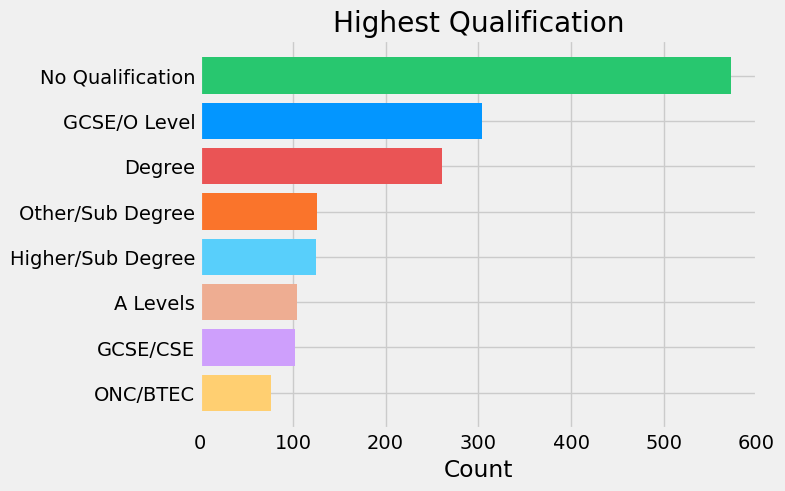

In [11]:
counts = [smoking_df['highest_qualification'].value_counts()[0], smoking_df['highest_qualification'].value_counts()[1], 
         smoking_df['highest_qualification'].value_counts()[2], smoking_df['highest_qualification'].value_counts()[3],
         smoking_df['highest_qualification'].value_counts()[4], smoking_df['highest_qualification'].value_counts()[5],
         smoking_df['highest_qualification'].value_counts()[6], smoking_df['highest_qualification'].value_counts()[7]]
labels = ['ONC/BTEC', 'GCSE/CSE', 'A Levels', 'Higher/Sub Degree', 'Other/Sub Degree', 'Degree', 'GCSE/O Level', 
          'No Qualification']
c = ['#FFCF71', '#CE9FFC', '#EEAD92', '#58CFFB', '#FA742B', '#EA5455', '#0396FF', '#28C76F']

counts.reverse()

plt.barh(labels, counts, color=c)

plt.xlabel('Count')
plt.title("Highest Qualification")
plt.show()

### 2.5 Nationality <a id='2_5'></a>

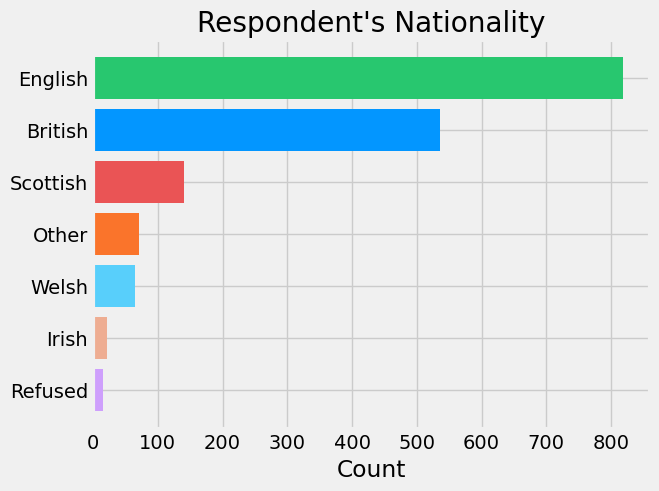

In [12]:
counts = [smoking_df['nationality'].value_counts()[0], smoking_df['nationality'].value_counts()[1], 
         smoking_df['nationality'].value_counts()[2], smoking_df['nationality'].value_counts()[3],
         smoking_df['nationality'].value_counts()[4], smoking_df['nationality'].value_counts()[5],
         smoking_df['nationality'].value_counts()[6]]
labels = ['Refused', 'Irish', 'Welsh', 'Other', 'Scottish',
          'British', 'English']
c = ['#CE9FFC', '#EEAD92', '#58CFFB', '#FA742B', '#EA5455', '#0396FF', '#28C76F']

counts.reverse()

plt.barh(labels, counts, color=c)

plt.xlabel('Count')
plt.title("Respondent's Nationality")
plt.show()

### 2.6 Ethnicity <a id='2_6'></a>

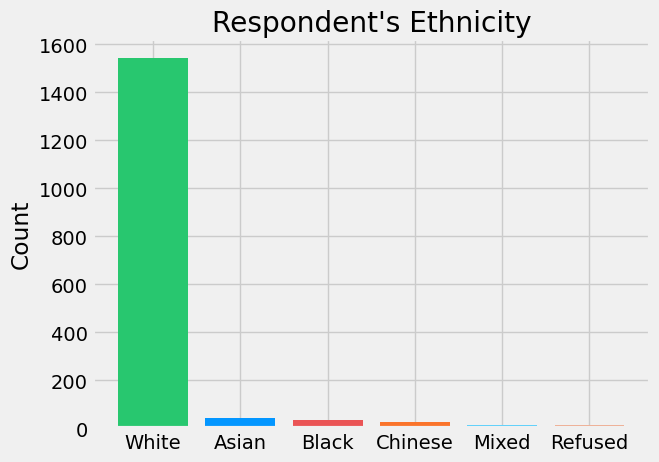

In [13]:
counts = [smoking_df['ethnicity'].value_counts()[0], smoking_df['ethnicity'].value_counts()[1], 
         smoking_df['ethnicity'].value_counts()[2], smoking_df['ethnicity'].value_counts()[3],
         smoking_df['ethnicity'].value_counts()[4], smoking_df['ethnicity'].value_counts()[5]]
labels = ['White', 'Asian', 'Black', 'Chinese', 'Mixed', 'Refused']
c = ['#28C76F', '#0396FF', '#EA5455', '#FA742B', '#58CFFB', '#EEAD92']

plt.bar(labels, counts, color=c)

plt.ylabel('Count')
plt.title("Respondent's Ethnicity")
plt.show()

### 2.7 Gross Income <a id='2_7'></a>

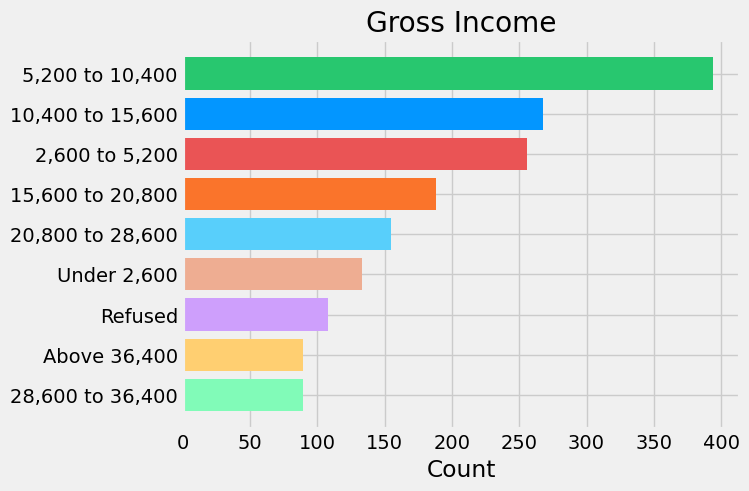

In [14]:
counts = [smoking_df['gross_income'].value_counts()[0], smoking_df['gross_income'].value_counts()[1], 
         smoking_df['gross_income'].value_counts()[2], smoking_df['gross_income'].value_counts()[3],
         smoking_df['gross_income'].value_counts()[4], smoking_df['gross_income'].value_counts()[5],
         smoking_df['gross_income'].value_counts()[6], smoking_df['gross_income'].value_counts()[7],
         smoking_df['gross_income'].value_counts()[7]]
labels = ['28,600 to 36,400', 'Above 36,400', 'Refused', 'Under 2,600', '20,800 to 28,600', '15,600 to 20,800',
          '2,600 to 5,200', '10,400 to 15,600', '5,200 to 10,400']
c = ['#81FBB8', '#FFCF71', '#CE9FFC', '#EEAD92', '#58CFFB', '#FA742B', '#EA5455', '#0396FF', '#28C76F']

counts.reverse()

plt.barh(labels, counts, color=c)

plt.xlabel('Count')
plt.title("Gross Income")
plt.show()

### 2.8 Region <a id='2_8'></a>

In [15]:
smoking_df['region'].value_counts()

Midlands & East Anglia    438
The North                 421
South East                249
London                    181
South West                154
Scotland                  147
Wales                      80
Name: region, dtype: int64

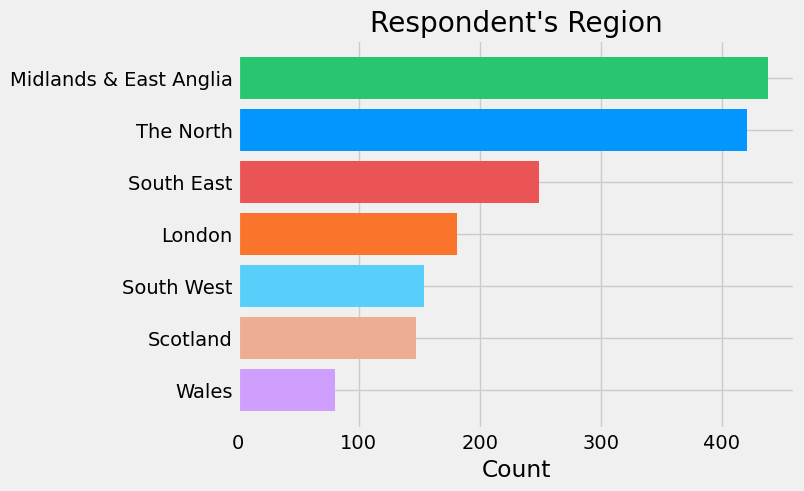

In [16]:
counts = [smoking_df['region'].value_counts()[0], smoking_df['region'].value_counts()[1], 
         smoking_df['region'].value_counts()[2], smoking_df['region'].value_counts()[3],
         smoking_df['region'].value_counts()[4], smoking_df['region'].value_counts()[5],
         smoking_df['region'].value_counts()[6]]
labels = ['Wales', 'Scotland', 'South West', 'London', 'South East',
          'The North', 'Midlands & East Anglia']
c = ['#CE9FFC', '#EEAD92', '#58CFFB', '#FA742B', '#EA5455', '#0396FF', '#28C76F']

counts.reverse()

plt.barh(labels, counts, color=c)

plt.xlabel('Count')
plt.title("Respondent's Region")
plt.show()

### 2.9 Smoke <a id='2_9'></a>

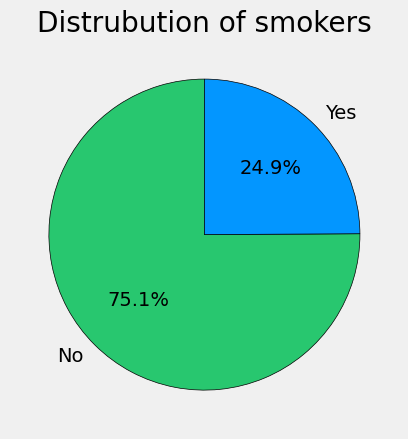

In [17]:
slices = [smoking_df['smoke'].value_counts()[0], smoking_df['smoke'].value_counts()[1]]
labels = ['No', 'Yes']
c = ['#28C76F', '#0396FF']

plt.pie(slices, labels=labels, startangle=90, autopct='%1.1f%%', colors=c, 
        wedgeprops={'edgecolor': 'black'})

plt.title("Distrubution of smokers")
plt.show()

#### Now let's see how smoking is related to other columns

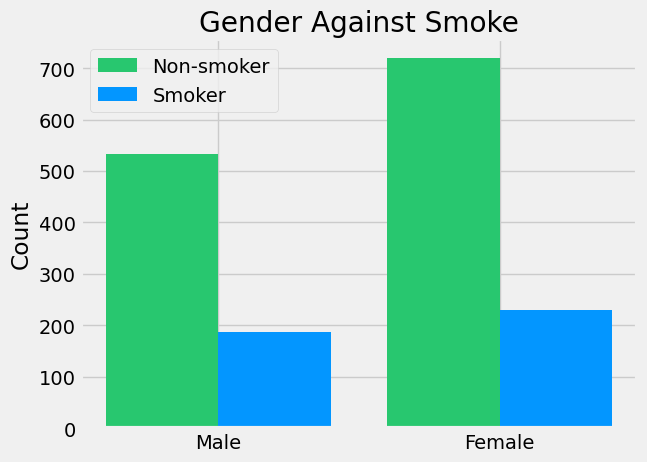

In [18]:
gender_smokers = {}

for gender in smoking_df['gender'].unique():
    gender_smokers[f'{gender}_smokers'] = len(smoking_df[(smoking_df['gender'] == gender) & (smoking_df['smoke'] == 'Yes')])
    gender_smokers[f'{gender}_non_smokers'] = len(smoking_df[(smoking_df['gender'] == gender) & (smoking_df['smoke'] == 'No')])

fig, ax = plt.subplots()
x = np.arange(len(smoking_df.gender.unique()))
width = 0.4

ax.bar(x, [gender_smokers['Male_non_smokers'], gender_smokers['Female_non_smokers']], 
       width=width, color='#28C76F', label='Non-smoker')
ax.bar(x + width, [gender_smokers['Male_smokers'], gender_smokers['Female_smokers']], 
       width=width, color='#0396FF', label='Smoker')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(smoking_df.gender.unique())

ax.legend()

plt.ylabel('Count')
plt.title("Gender Against Smoke")
plt.show()

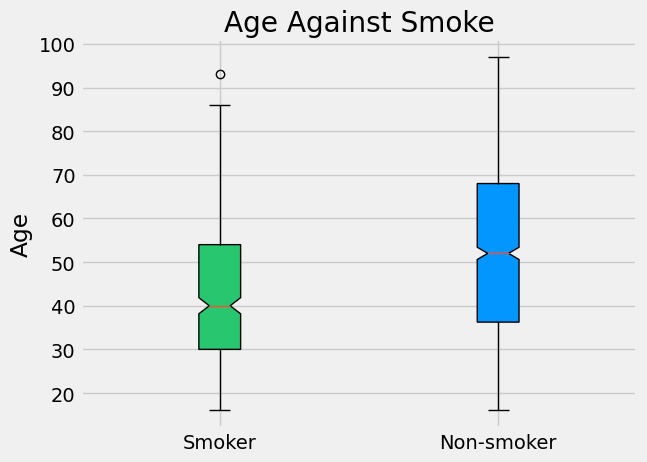

In [19]:
age_smokers = smoking_df.loc[smoking_df['smoke'] == 'Yes', ['age']]
age_non_smokers = smoking_df.loc[smoking_df['smoke'] == 'No', ['age']]
data = [age_smokers.values.flatten(), age_non_smokers.values.flatten()]

fig, ax = plt.subplots()
labels = ['Smoker', 'Non-smoker']
colors = ['#28C76F', '#0396FF']

bplot = ax.boxplot(data, labels=labels, notch=True, vert=True, patch_artist=True)

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.ylabel('Age')
plt.title("Age Against Smoke")
plt.show()

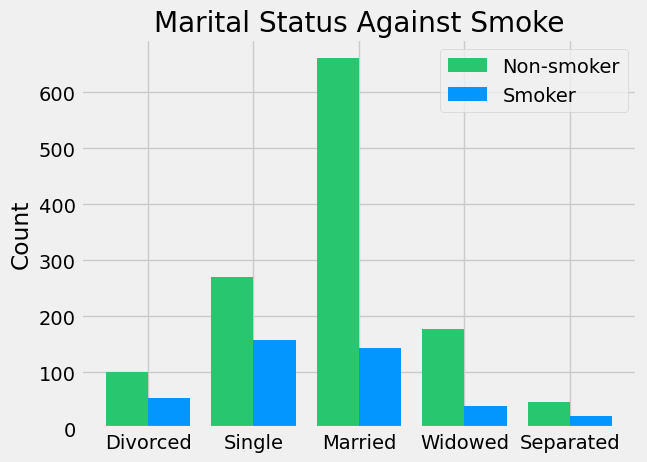

In [20]:
ms_smokers = {}

for ms in smoking_df['marital_status'].unique():
    ms_smokers[f'{ms}_smokers'] = len(smoking_df[(smoking_df['marital_status'] == ms) & (smoking_df['smoke'] == 'Yes')])
    ms_smokers[f'{ms}_non_smokers'] = len(smoking_df[(smoking_df['marital_status'] == ms) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.marital_status.unique()))
width = 0.4

ax.bar(x, [ms_smokers['Divorced_non_smokers'], ms_smokers['Single_non_smokers'], ms_smokers['Married_non_smokers'],
           ms_smokers['Widowed_non_smokers'], ms_smokers['Separated_non_smokers']], 
       width=width, color='#28C76F', label='Non-smoker')
ax.bar(x + width, [ms_smokers['Divorced_smokers'], ms_smokers['Single_smokers'], ms_smokers['Married_smokers'],
                   ms_smokers['Widowed_smokers'], ms_smokers['Separated_smokers']], 
       width=width, color='#0396FF', label='Smoker')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(smoking_df.marital_status.unique())

ax.legend()

plt.ylabel('Count')
plt.title("Marital Status Against Smoke")
plt.show()

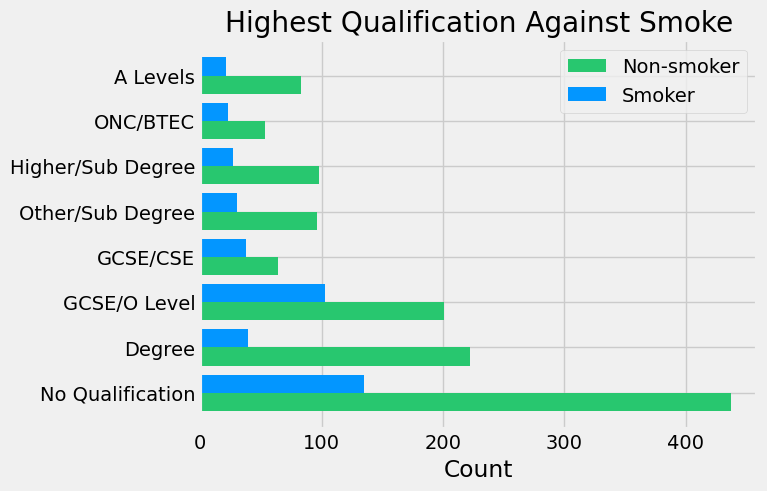

In [21]:
hq_smokers = {}

for hq in smoking_df['highest_qualification'].unique():
    hq_smokers[f'{hq}_smokers'] = len(smoking_df[(smoking_df['highest_qualification'] == hq) & (smoking_df['smoke'] == 'Yes')])
    hq_smokers[f'{hq}_non_smokers'] = len(smoking_df[(smoking_df['highest_qualification'] == hq) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.highest_qualification.unique()))
width = 0.4

ax.barh(x, [hq_smokers['No Qualification_non_smokers'], hq_smokers['Degree_non_smokers'], hq_smokers['GCSE/O Level_non_smokers'],
            hq_smokers['GCSE/CSE_non_smokers'], hq_smokers['Other/Sub Degree_non_smokers'], 
            hq_smokers['Higher/Sub Degree_non_smokers'], hq_smokers['ONC/BTEC_non_smokers'], hq_smokers['A Levels_non_smokers']], 
       height=width, color='#28C76F', label='Non-smoker')
ax.barh(x + width, [hq_smokers['No Qualification_smokers'], hq_smokers['Degree_smokers'], hq_smokers['GCSE/O Level_smokers'],
                    hq_smokers['GCSE/CSE_smokers'], hq_smokers['Other/Sub Degree_smokers'], 
                    hq_smokers['Higher/Sub Degree_smokers'], hq_smokers['ONC/BTEC_smokers'], hq_smokers['A Levels_smokers']], 
       height=width, color='#0396FF', label='Smoker')

ax.set_yticks(x + width / 2)
ax.set_yticklabels(smoking_df.highest_qualification.unique())

ax.legend()

plt.xlabel('Count')
plt.title("Highest Qualification Against Smoke")
plt.show()

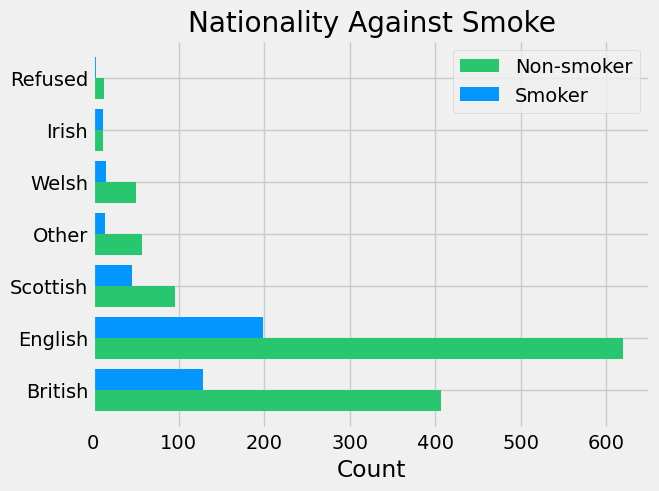

In [22]:
nat_smokers = {}

for nat in smoking_df['nationality'].unique():
    nat_smokers[f'{nat}_smokers'] = len(smoking_df[(smoking_df['nationality'] == nat) & (smoking_df['smoke'] == 'Yes')])
    nat_smokers[f'{nat}_non_smokers'] = len(smoking_df[(smoking_df['nationality'] == nat) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.nationality.unique()))
width = 0.4

ax.barh(x, [nat_smokers['British_non_smokers'], nat_smokers['English_non_smokers'], nat_smokers['Scottish_non_smokers'],
            nat_smokers['Other_non_smokers'], nat_smokers['Welsh_non_smokers'], nat_smokers['Irish_non_smokers'], 
            nat_smokers['Refused_non_smokers']], 
       height=width, color='#28C76F', label='Non-smoker')
ax.barh(x + width, [nat_smokers['British_smokers'], nat_smokers['English_smokers'], nat_smokers['Scottish_smokers'],
                    nat_smokers['Other_smokers'], nat_smokers['Welsh_smokers'], nat_smokers['Irish_smokers'], 
                    nat_smokers['Refused_smokers']], 
       height=width, color='#0396FF', label='Smoker')

ax.set_yticks(x + width / 2)
ax.set_yticklabels(smoking_df.nationality.unique())

ax.legend()

plt.xlabel('Count')
plt.title("Nationality Against Smoke")
plt.show()

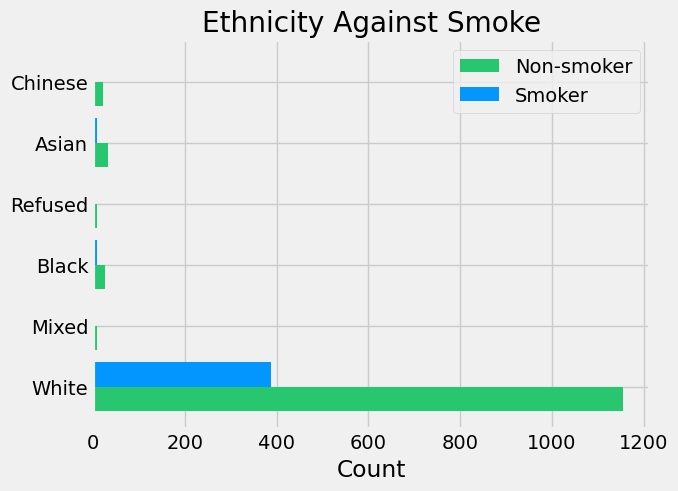

In [23]:
eth_smokers = {}

for eth in smoking_df['ethnicity'].unique():
    eth_smokers[f'{eth}_smokers'] = len(smoking_df[(smoking_df['ethnicity'] == eth) & (smoking_df['smoke'] == 'Yes')])
    eth_smokers[f'{eth}_non_smokers'] = len(smoking_df[(smoking_df['ethnicity'] == eth) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.ethnicity.unique()))
width = 0.4

ax.barh(x, [eth_smokers['White_non_smokers'], eth_smokers['Mixed_non_smokers'], eth_smokers['Black_non_smokers'],
            eth_smokers['Refused_non_smokers'], eth_smokers['Asian_non_smokers'], eth_smokers['Chinese_non_smokers']], 
       height=width, color='#28C76F', label='Non-smoker')
ax.barh(x + width, [eth_smokers['White_smokers'], eth_smokers['Mixed_smokers'], eth_smokers['Black_smokers'],
                    eth_smokers['Refused_smokers'], eth_smokers['Asian_smokers'], eth_smokers['Chinese_smokers']], 
       height=width, color='#0396FF', label='Smoker')

ax.set_yticks(x + width / 2)
ax.set_yticklabels(smoking_df.ethnicity.unique())

ax.legend()

plt.xlabel('Count')
plt.title("Ethnicity Against Smoke")
plt.show()

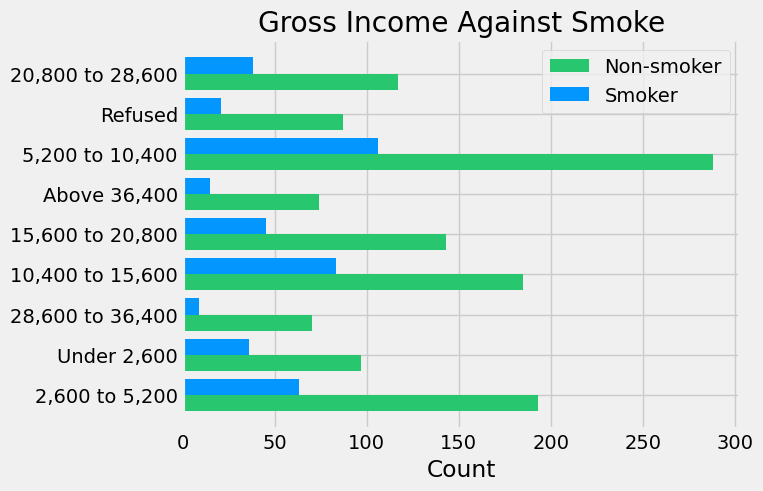

In [24]:
gi_smokers = {}

for gi in smoking_df['gross_income'].unique():
    gi_smokers[f'{gi}_smokers'] = len(smoking_df[(smoking_df['gross_income'] == gi) & (smoking_df['smoke'] == 'Yes')])
    gi_smokers[f'{gi}_non_smokers'] = len(smoking_df[(smoking_df['gross_income'] == gi) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.gross_income.unique()))
width = 0.4

ax.barh(x, [gi_smokers['2,600 to 5,200_non_smokers'], gi_smokers['Under 2,600_non_smokers'], 
            gi_smokers['28,600 to 36,400_non_smokers'], gi_smokers['10,400 to 15,600_non_smokers'], 
            gi_smokers['15,600 to 20,800_non_smokers'], gi_smokers['Above 36,400_non_smokers'], 
            gi_smokers['5,200 to 10,400_non_smokers'], gi_smokers['Refused_non_smokers'], 
            gi_smokers['20,800 to 28,600_non_smokers']], 
       height=width, color='#28C76F', label='Non-smoker')
ax.barh(x + width, [gi_smokers['2,600 to 5,200_smokers'], gi_smokers['Under 2,600_smokers'], 
                    gi_smokers['28,600 to 36,400_smokers'], gi_smokers['10,400 to 15,600_smokers'], 
                    gi_smokers['15,600 to 20,800_smokers'], gi_smokers['Above 36,400_smokers'], 
                    gi_smokers['5,200 to 10,400_smokers'], gi_smokers['Refused_smokers'], 
                    gi_smokers['20,800 to 28,600_smokers']], 
       height=width, color='#0396FF', label='Smoker')

ax.set_yticks(x + width / 2)
ax.set_yticklabels(smoking_df.gross_income.unique())

ax.legend()

plt.xlabel('Count')
plt.title("Gross Income Against Smoke")
plt.show()

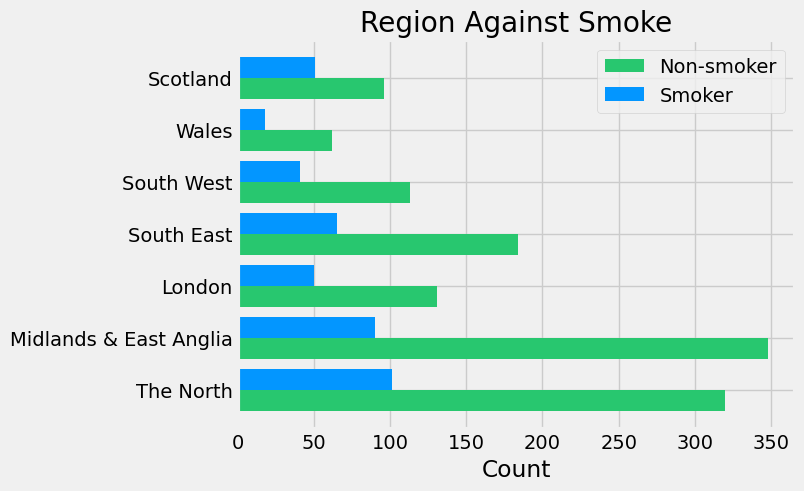

In [25]:
reg_smokers = {}

for reg in smoking_df['region'].unique():
    reg_smokers[f'{reg}_smokers'] = len(smoking_df[(smoking_df['region'] == reg) & (smoking_df['smoke'] == 'Yes')])
    reg_smokers[f'{reg}_non_smokers'] = len(smoking_df[(smoking_df['region'] == reg) & (smoking_df['smoke'] == 'No')])
    
fig, ax = plt.subplots()
x = np.arange(len(smoking_df.region.unique()))
width = 0.4

ax.barh(x, [reg_smokers['The North_non_smokers'], reg_smokers['Midlands & East Anglia_non_smokers'], 
            reg_smokers['London_non_smokers'], reg_smokers['South East_non_smokers'], reg_smokers['South West_non_smokers'], 
            reg_smokers['Wales_non_smokers'], reg_smokers['Scotland_non_smokers']], 
       height=width, color='#28C76F', label='Non-smoker')
ax.barh(x + width, [reg_smokers['The North_smokers'], reg_smokers['Midlands & East Anglia_smokers'], 
                    reg_smokers['London_smokers'], reg_smokers['South East_smokers'], reg_smokers['South West_smokers'], 
                    reg_smokers['Wales_smokers'], reg_smokers['Scotland_smokers']], 
       height=width, color='#0396FF', label='Smoker')

ax.set_yticks(x + width / 2)
ax.set_yticklabels(smoking_df.region.unique())

ax.legend()

plt.xlabel('Count')
plt.title("Region Against Smoke")
plt.show()

## 3. XGBoost Classification <a id='3'></a>

### 3.1 Encoding categorical columns <a id='3_1'></a>

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_cols = ['gender', 'marital_status', 'highest_qualification', 'nationality', 'ethnicity', 'gross_income', 'region', 'smoke']

for col in cat_cols:
    smoking_df[col] = le.fit_transform(smoking_df[col])
    
smoking_df.head()

,gender,age,marital_status,highest_qualification,nationality,ethnicity,gross_income,region,smoke
id,,,,,,,,,
1,1,38,0,5,0,5,2,5,0
2,0,42,3,5,0,5,8,5,1
3,1,40,1,1,1,5,4,5,0
4,0,40,1,1,1,5,0,5,0
5,0,39,1,3,0,5,2,5,0


### 3.2 Splitting the data and dealing with class imbalance <a id='3_2'></a>

In [27]:
print(smoking_df['smoke'].value_counts())

0    1254
1     416
Name: smoke, dtype: int64


In [28]:
from sklearn.utils import resample

X, y = smoking_df.drop('smoke', axis=1), smoking_df['smoke']

# Fixing the imbalance
X_upsampled, y_upsampled = resample(X[y == 1],
                                    y[y == 1],
                                    replace=True,
                                    n_samples=X[y == 0].shape[0],
                                    random_state=123)

X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [29]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, 
    test_size=0.2, 
    random_state=1, 
    stratify=y_bal)

### 3.3 Creating the XGB model and tuning hyperparameters via grid search <a id='3_3'></a>

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective='binary:logistic', nthread=-1, random_state=1)

# Specifying tunable parameters and range of values
parameters = {
    'max_depth': range (2, 12, 1),
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.05]
}

# Configuring the GridSearchCV object, using 10-fold cross-validation
gs = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10
)

gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 12),
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc')

In [31]:
gs.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=-1,
              num_parallel_tree=None, predictor=None, ...)

In [32]:
y_pred = gs.best_estimator_.predict(X_test)
test_acc = gs.best_estimator_.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.880


### 3.4 Performace evaluation <a id='3_4'></a>

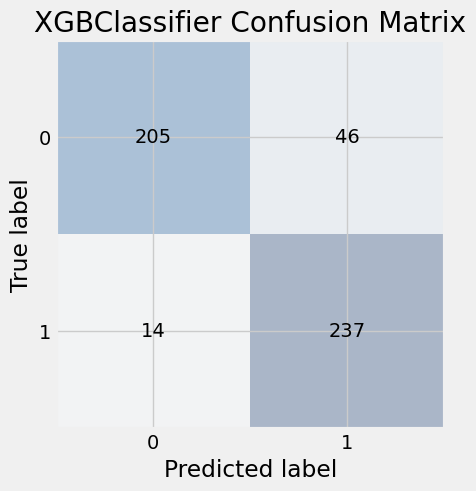

In [33]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots()
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.title('XGBClassifier Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

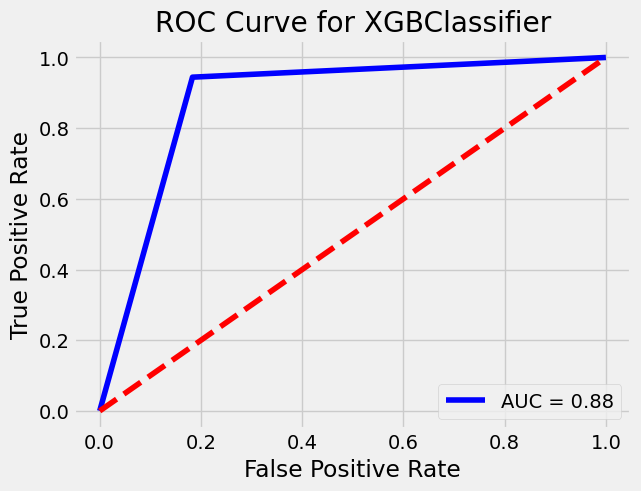

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.title('ROC Curve for XGBClassifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

By using grid search for tuning hyperparameters, we were able to find the best combination of parameters for our XGB classification model and our best estimator scored <strong>88% acccuracy</strong> on the test set.